## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [343]:
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
# return the probability of each classes
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score


def gini(sequence, weight=None):
    if weight is None:
        class_seq, cnt = np.unique(sequence.astype(np.int32), return_counts=True)
        p = cnt / sequence.shape[0]
        return 1 - np.sum(p ** 2)
    if len(weight) == 0:
        return 0
    p = np.sum(weight[sequence == 0]) / np.sum(weight)
    return 1 - p ** 2 - (1-p) ** 2
    

def entropy(sequence, weight=None):
    if weight is None:
        class_seq, cnt = np.unique(sequence.astype(np.int32), return_counts=True)
        p = cnt / sequence.shape[0]
        # p != 0 because unique will not return an element that's not in the sequence
        return (-1) * np.sum(p * np.log2(p))
    if len(weight) == 0:
        return 0
    p = np.sum(np.where(sequence == 0, weight, 0)) / np.sum(weight)
    return (-1) * (p * np.log2(p) + (1-p) * np.log2((1-p)))


In [344]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [345]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [346]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [347]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('x_test.csv')
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

x_train = train_df.drop(labels=["price_range"], axis="columns")
feature_names = x_train.columns.values
x_train = x_train.values
y_train = train_df['price_range'].values

x_test = val_df.drop(labels=["price_range"], axis="columns")
x_test = x_test.values
y_test = val_df['price_range'].values

x_test_q6 = test_df.values

print("x_train:", type(x_train))
print("y_train:", type(y_train))
print("x_test:", type(x_test))
print("y_test:", type(y_test))
print("x_test_q6:", type(x_test_q6))

(1200, 21)
(300, 21)
(500, 20)
x_train: <class 'numpy.ndarray'>
y_train: <class 'numpy.ndarray'>
x_test: <class 'numpy.ndarray'>
y_test: <class 'numpy.ndarray'>
x_test_q6: <class 'numpy.ndarray'>


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [348]:
class Question():
    def __init__(self, column, value):
        self.column = column
        self.value = value
        pass

    def match(self, row):
        val = row[self.column]
        return val >= self.value


class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, k_features=None, sample_weight=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.n_features = None
        self.root = None
        self.k_features = k_features
        self.feature_count = {}
        self.sample_weight = sample_weight
        if criterion == 'gini':
            self.measureFunc = gini
        else:
            self.measureFunc = entropy
        return None

    class TreeNode():
        def __init__(self):
            self.rows = None
            self.gain = None
            self.question = None
            self.pred = None
            self.left = None
            self.right = None
            return None

    def Informationgain(self, left_rows, right_rows, currentImpurity, l_weight=None, r_weight=None):
        if l_weight is not None and r_weight is not None:
            p = np.sum(l_weight) / (np.sum(l_weight) + np.sum(r_weight))
        else:
            p = float(len(left_rows)) / (len(left_rows) + len(right_rows))
        return currentImpurity - p * self.measureFunc(left_rows[:, -1].astype(np.int32), weight=l_weight) - (1 - p) * self.measureFunc(right_rows[:, -1].astype(np.int32), weight=r_weight)

    def find_best_split(self, rows):
        """Find the best split by repeating asking whether a property of a data is greater than thresholds
        generated by sorting N data using each property

        Args:
            rows (N,21): includes 20 properties and 1 columns representing the class of each row.
        """
        best_gain = 0
        best_question = None
        current_impurity = self.measureFunc(rows[:, -1].astype(np.int32), weight=self.sample_weight)

        # for random forest
        if self.k_features is not None:
            # choose $(max_features) features from data
            if self.k_features > self.n_features-1:
                n_cols = np.arange(self.n_features-1) # [0,21)
            else:
                n_cols = random.sample(range(self.n_features-1), k=self.k_features)
        else:
            n_cols = np.arange(self.n_features-1) # [0, 21)
        # for each feature
        for col in n_cols:

            # Try N threshold values
            for idx in range(len(rows)):
                current_threshold = rows[idx, col]

                # is data[col] >= current_threshold ?
                # if it's binary, the threshold is 0.5, so it's ok to use '>=' to compare
                # if it's real value, also valid to use '>=' to compare
                question = Question(column=col,
                                    value=current_threshold)

                # split the data using current question
                # true and false are candidates for best split(potential child nodes)
                true_rows = rows[rows[:, col] >= current_threshold]
                false_rows = rows[rows[:, col] < current_threshold]
                if self.sample_weight is not None:
                    left_weight = self.sample_weight[rows[:, col] >= current_threshold]
                    right_weight = self.sample_weight[rows[:, col] < current_threshold]
                else:
                    left_weight = None
                    right_weight = None
                
                current_gain = self.Informationgain(left_rows=true_rows,
                                                    right_rows=false_rows,
                                                    currentImpurity=current_impurity,
                                                    l_weight=left_weight,
                                                    r_weight=right_weight)

                if current_gain >= best_gain or best_question is None:
                    best_gain, best_question = current_gain, question

        label = train_df.columns[best_question.column]
        if self.feature_count.get(label) is not None:
            self.feature_count[label] = self.feature_count[label] + 1
        else:
            self.feature_count[label] = 1
        return current_gain, best_question


    def generateTree(self, rows, cur_depth=None):
        """Generate the decision tree

        Args:
            rows (N,21): includes 20 properties and 1 columns representing the class of each row.
            cur_depth: keep subtract until 0, the recursion will terminate when cur_depth = 0 or the node is pure
            dist: for adaboost, use distribution to calculate the error and find best split
        """
        cur_node = self.TreeNode()
        if self.measureFunc(sequence=rows[:, -1].astype(np.int32)) == 0:
            cur_node.pred = int(rows[0, -1])
        elif cur_depth == 0:
            if np.count_nonzero(rows[:, -1].astype(np.int32)) >= rows.shape[0] / 2:
                cur_node.pred = 1
            else:
                cur_node.pred = 0
        else:
            best_gain, best_question = self.find_best_split(rows=rows)
            cur_node.rows = rows
            cur_node.gain = best_gain
            cur_node.question = best_question
            left_child  = rows[rows[:, best_question.column] >= best_question.value]
            right_child = rows[rows[:, best_question.column] < best_question.value]
            if len(left_child) == 0:
                cur_node.pred = int(right_child[0, -1])
                return cur_node
            if len(right_child) == 0:
                cur_node.pred = int(left_child[0, -1])
                return cur_node
            if cur_depth is None:
                cur_node.left = self.generateTree(rows=left_child)
                cur_node.right = self.generateTree(rows=right_child)
            else:
                cur_node.left = self.generateTree(
                    rows=left_child, cur_depth=cur_depth-1)
                cur_node.right = self.generateTree(
                    rows=right_child, cur_depth=cur_depth-1)
        return cur_node

    # Generate Tree by fitting data
    def fit(self, x_data, y_data):
        self.feature_count = {}
        y_data = y_data[:, np.newaxis]
        rows = np.hstack((x_data, y_data))
        self.n_features = rows.shape[1] # 21
        self.root = self.generateTree(rows=rows, cur_depth=self.max_depth)
    

    def feature_importance(self):
        fi = []
        for key in self.feature_count.keys():
            fi.append(self.feature_count[key])
        return fi

    def traverse(self, cur_node, x_data):
        if cur_node.pred is not None:
            return cur_node.pred
        if cur_node.question.match(x_data) == 1:
            return self.traverse(cur_node=cur_node.left, x_data=x_data)
        else:
            return self.traverse(cur_node=cur_node.right, x_data=x_data)

    def print_acc(self, ans, pred):
        diff = np.sum(np.where(ans != pred, 1, 0))
        acc = 1 - diff / len(pred)
        print(f'criterion = {self.criterion}')
        print(f'max depth = {self.max_depth}')
        print(f'acc       = {acc}')
        print('====================')
    def get_feature_count(self):
        print(self.feature_count)
        return

    # After fitting, use the gererated tree to predict x_data
    def predict(self, x_data): # x_data doesn't contain label
        pred = []
        for row in x_data:
            ans = self.traverse(cur_node=self.root, x_data=row)
            pred.append(ans)
        return np.array(pred)

In [349]:
print('Decision Tree')
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(x_data=x_train, y_data=y_train)
clf_depth3.get_feature_count()
pred = clf_depth3.predict(x_data=x_test)
print(f'gini_depth3\'s accuracy_score: {accuracy_score(y_test, pred)}')

clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(x_data=x_train, y_data=y_train)
clf_depth10.get_feature_count()
pred = clf_depth10.predict(x_data=x_test)
print(f'gini_depth10 accuracy_score: {accuracy_score(y_test, pred)}')

Decision Tree
{'ram': 3, 'battery_power': 3, 'px_height': 1}
gini_depth3's accuracy_score: 0.92
{'ram': 9, 'battery_power': 8, 'px_height': 10, 'talk_time': 4, 'sc_h': 2, 'wifi': 3, 'px_width': 5, 'm_dep': 1, 'mobile_wt': 1, 'touch_screen': 2, 'sc_w': 1, 'fc': 1}
gini_depth10 accuracy_score: 0.9433333333333334


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [350]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(x_data=x_train, y_data=y_train)
clf_gini.get_feature_count()
pred = clf_gini.predict(x_data=x_test)
print(f'gini_depth3\'s accuracy_score: {accuracy_score(y_test, pred)}')

clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(x_data=x_train, y_data=y_train)
clf_entropy.get_feature_count()
pred = clf_entropy.predict(x_data=x_test)
print(f'entropy_depth3\'s accuracy_score: {accuracy_score(y_test, pred)}')

{'ram': 3, 'battery_power': 3, 'px_height': 1}
gini_depth3's accuracy_score: 0.92
{'ram': 3, 'battery_power': 3, 'px_height': 1}
entropy_depth3's accuracy_score: 0.9333333333333333


- Note: Your decisition tree scores should over **0.7**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

dict_keys(['m_dep', 'mobile_wt', 'sc_w', 'fc', 'sc_h', 'touch_screen', 'wifi', 'talk_time', 'px_width', 'battery_power', 'ram', 'px_height'])
dict_values([1, 1, 1, 1, 2, 2, 3, 4, 5, 8, 9, 10])


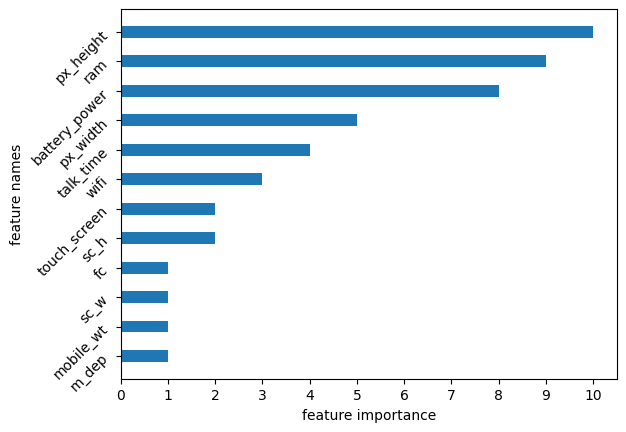

In [351]:
# ## Question 3
# Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

# feature_sorted = dict(sorted(clf_depth3.feature_count.items(), key=lambda item: item[1]))
# feature_names = feature_sorted.keys()
# print(feature_names)
# feature_counts = feature_sorted.values()
# print(feature_counts)

# x_pos = [x for x,_ in enumerate(feature_names)]
# plt.barh(x_pos, feature_counts, height=0.4)
# plt.ylabel('feature names')
# plt.xlabel('feature importance')
# plt.xticks(np.arange(max(feature_counts)+1))
# plt.yticks(x_pos, feature_names, rotation=45)
# plt.gca().grid(axis='x', which='major')
# plt.tight_layout()
# plt.savefig('fi_gini_d3.png', dpi=300, transparent=False)
# plt.clf()

feature_sorted = dict(sorted(clf_depth10.feature_count.items(), key=lambda item: item[1]))
feature_names = feature_sorted.keys()
print(feature_names)
feature_counts = feature_sorted.values()
print(feature_counts)

x_pos = [x for x,_ in enumerate(feature_names)]
plt.barh(x_pos, feature_counts, height=0.4)
plt.ylabel('feature names')
plt.xlabel('feature importance')
plt.xticks(np.arange(max(feature_counts)+1))
plt.yticks(x_pos, feature_names, rotation=45)
plt.show()

# feature_sorted = dict(sorted(clf_entropy.feature_count.items(), key=lambda item: item[1]))
# feature_names = feature_sorted.keys()
# print(feature_names)
# feature_counts = feature_sorted.values()
# print(feature_counts)

# x_pos = [x for x,_ in enumerate(feature_names)]
# plt.barh(x_pos, feature_counts, height=0.4)
# plt.ylabel('feature names')
# plt.xlabel('feature importance')
# plt.xticks(np.arange(max(feature_counts)+1))
# plt.yticks(x_pos, feature_names, rotation=45)
# plt.gca().grid(axis='x', which='major')
# plt.tight_layout()
# plt.savefig('fi_entropy_d3.png', dpi=300, transparent=False)
# plt.clf()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [352]:
class AdaBoost():
    def __init__(self, n_estimators, criterion='gini'):
        self.n_estimators = n_estimators
        self.criterion = criterion
        if criterion == 'gini':
            self.meas_func = gini
        else:
            self.meas_func = entropy
        self.n_trees = [DecisionTree(self.criterion, max_depth=1) for i in range(n_estimators)]
        self.distribution = None
        self.weight = []
        return None
    
    def get_feature_count(self):
        for iter in range(self.n_estimators):
            self.n_trees[iter].get_feature_count()
        return 

    def print_acc(self, ans, pred):
        diff = np.sum(np.where(ans != pred, 1, 0))
        acc = 1 - diff / len(pred)
        print(f'criterion = {self.criterion}')
        print(f'acc       = {acc}')
        print('====================')
    
    def fit(self, x_data, y_data):
        self.distribution = np.repeat(1 / x_data.shape[0], x_data.shape[0])
        for iter in range(self.n_estimators):
            self.n_trees[iter].sample_weight = self.distribution
            self.n_trees[iter].fit(x_data=x_data, y_data=y_data)
            
            # predict
            pred = self.n_trees[iter].predict(x_data)
            pred = np.where(pred != y_data, 1, 0)

            error_t = np.sum(pred * self.distribution)
            weight_t = (0.5) * np.log((1-error_t) / (error_t))
            self.weight.append(weight_t)
        
            # wrong pred => -1, right pred => 1
            pred = np.where(pred == 0, 1, -1)
            self.distribution = self.distribution * np.exp((-1) * weight_t * pred)
            self.distribution = self.distribution / np.sum(self.distribution)
            
        self.weight = np.array(self.weight)

    def predict(self, x_data):
        pred = np.zeros((len(x_data), self.n_estimators))
        rows = x_data[:, 0:20]
        for iter in range(self.n_estimators):
            # prediction of iter-th tree on all data
            pred_i = self.n_trees[iter].predict(x_data=rows)
            pred_i = np.where(pred_i == 0, -1, 1)
            pred[:, iter] = pred_i
        total = np.sum(self.weight[np.newaxis, :] * pred, axis=1)
        total = np.where(total >= 0, 1, 0)
        return total

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [353]:
print('Adaboost')
ada_10est = AdaBoost(n_estimators=10)
ada_10est.fit(x_data=x_train, y_data=y_train)
pred = ada_10est.predict(x_data=x_test)
print(f'n=10\'s accuracy_score: {accuracy_score(y_test, pred)}')

ada_100est = AdaBoost(n_estimators=100)
ada_100est.fit(x_data=x_train, y_data=y_train)
pred = ada_100est.predict(x_data=x_test)
print(f'n=100\'s accuracy_score: {accuracy_score(y_test, pred)}')

Adaboost
n=10's accuracy_score: 0.95
n=100's accuracy_score: 0.9766666666666667


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [354]:
class RandomForest():
    def __init__(self, n_estimators, max_features, bootstrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = int(np.round(max_features))
        self.use_bootstrap = bootstrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.n_trees = [DecisionTree(self.criterion, self.max_depth, self.max_features) for i in range(self.n_estimators)]
        return None
    
    def get_feature_count(self):
        for iter in range(self.n_estimators):
            self.n_trees[iter].get_feature_count()
        return 

    def fit(self, x_data, y_data):
        for iter in range(self.n_estimators):
            if self.use_bootstrap == True:
                # draw N random samples from dataset
                n_rows = np.random.randint(x_data.shape[0], size=len(x_data))
                rows = x_data[n_rows]
                self.n_trees[iter].fit(np.array(rows), y_data[n_rows])
            else:
                self.n_trees[iter].fit(x_data=x_data, y_data=y_data)
        return

    def print_acc(self, ans, pred):
        diff = np.sum(np.where(ans != pred, 1, 0))
        acc = 1 - diff / len(pred)
        print(f'n estimators = {self.n_estimators}')
        print(f'max features = {self.max_features}')
        print(f'boostrap     = {self.use_bootstrap}')
        print(f'criterion    = {self.criterion}')
        print(f'max depth    = {self.max_depth}')
        print(f'acc          = {acc}')
        print('====================')

    def predict(self, x_data):
        x_pred = []
        for row in x_data:
            row = row[np.newaxis, :]
            vote_now = []
            for tree_k in self.n_trees:
                pred = tree_k.predict(x_data=row)
                vote_now.append(pred)
            label, cnt = np.unique(vote_now, return_counts=True)
            vote_now = label[np.argmax(cnt)]
            x_pred.append(vote_now)
        return np.array(x_pred)

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [355]:
print('Random Forest()')
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]), max_depth=None, criterion='gini')
clf_10tree.fit(x_data=x_train, y_data=y_train)
pred = clf_10tree.predict(x_data=x_test)
print(f'n_estimator=10\'s accuracy_score: {accuracy_score(y_test, pred)}')
# clf_10tree.print_acc(y_test, pred)

clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(x_train.shape[1]), max_depth=None, criterion='gini')
clf_100tree.fit(x_data=x_train, y_data=y_train)
pred = clf_100tree.predict(x_data=x_test)
print(f'n_estimator=100\'s accuracy_score: {accuracy_score(y_test, pred)}')
# # clf_100tree.print_acc(y_test, pred)

Random Forest()
n_estimator=10's accuracy_score: 0.9233333333333333
n_estimator=100's accuracy_score: 0.93


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [356]:
print('Random Forest-2()')
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(x_train.shape[1]))
clf_random_features.fit(x_data=x_train, y_data=y_train)
pred = clf_random_features.predict(x_data=x_test)
print(f'sqrt(N) features accuracy_score: {accuracy_score(y_test, pred)}')
# clf_random_features.print_acc(y_test, pred)

clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])
clf_all_features.fit(x_data=x_train, y_data=y_train)
pred = clf_all_features.predict(x_data=x_test)
print(f'All features accuracy_score: {accuracy_score(y_test, pred)}')
# clf_all_features.print_acc(y_test, pred)

Random Forest-2()
sqrt(N) features accuracy_score: 0.9233333333333333
All features accuracy_score: 0.95


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [357]:
def train_your_model(data):
    x_train = data.drop(labels=["price_range"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = data['price_range'].values

    print("x_train:", type(x_train))
    print("y_train:", type(y_train))
    ## Define your model and training 
    ada_30est = AdaBoost(n_estimators=32)
    ada_30est.fit(x_data=x_train, y_data=y_train)
    return ada_30est

In [358]:
my_model = train_your_model(train_df)

x_train: <class 'numpy.ndarray'>
y_train: <class 'numpy.ndarray'>


In [359]:
y_pred = my_model.predict(x_test)
print(f'my model accuracy_score: {accuracy_score(y_test, y_pred)}')
# y_pred = my_model.predict(x_test_q6)
# print(f'my model accuracy_score: {accuracy_score(y_test, y_pred)}')

my model accuracy_score: 0.9766666666666667


In [360]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [361]:
import pandas as pd
from sklearn.metrics import accuracy_score

y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

In [362]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")


*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
